In [1]:
import torchvision.transforms as transforms
import torchvision.transforms as transforms
from PIL import Image
import onnxruntime as ort
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import torch

# Load the ONNX model
session = ort.InferenceSession("./fcn.onnx")

# Load pt model
modelPt = torch.load("./bestModelFinal.pt", map_location=torch.device("cpu"))

# Load image and preprocess it
image = Image.open("./fcn_data/images/rgb_0006.png")
input_name = session.get_inputs()[0].name
image = torch.tensor(np.expand_dims(np.array(image), axis=0), dtype=torch.float32)[
    :, :, :, :3
]
resize = transforms.Resize((640, 640))
image = image.permute(0, 3, 2, 1)
image = resize(image)
image = image.permute(0, 3, 2, 1) / 255

In [2]:
color_map = {
    0: [0, 0, 0],
    1: [25, 82, 255],
    2: [255, 25, 197],
    3: [140, 255, 25],
    4: [226, 255, 25],
    5: [255, 197, 25],
    6: [140, 25, 255],
    7: [54, 255, 25],
    8: [25, 255, 82],
    9: [255, 111, 25],
}

In [3]:
def convert_index_to_image(index, color_map):
    """
    Converts a batch of class probability tensors to images.

    Args:
        index: A torch tensor of shape [batch_size, num_classes, height, width] with class probabilities.
        color_map: A dictionary mapping class indices to color values.

    Returns:
        A torch tensor of shape [batch_size, height, width, 3] representing the images.
    """

    # Take the argmax over the class dimension (axis=1)
    max_class = torch.argmax(index, dim=1)  # Shape [batch_size, height, width]

    # Initialize an output image tensor with the same batch size, height, and width, but with 3 channels for RGB
    batch_size, height, width = max_class.shape
    output_image = torch.zeros((batch_size, height, width, 3), dtype=torch.uint8)

    # Vectorized mapping of class indices to RGB colors for each image in the batch
    for class_idx, color in color_map.items():
        output_image[max_class == class_idx] = torch.tensor(color, dtype=torch.uint8)

    return output_image

In [4]:
# Measure inference time with ONNX Runtime
start_time = time.time()
onnxOutputs = session.run(None, {input_name: np.array(image)})[0]
end_time = time.time()
print("ONNX Inference Time:", end_time - start_time)
# Measure inference time with ONNX Runtime
start_time = time.time()
ptOutputs = modelPt(image)
end_time = time.time()
print("PT Inference Time:", end_time - start_time)

ONNX Inference Time: 2.178398609161377
PT Inference Time: 2.4935781955718994


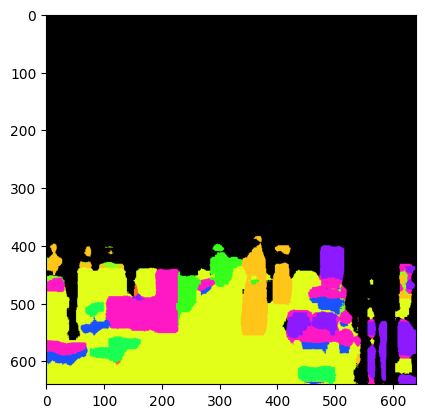

In [5]:
ptMask = convert_index_to_image(ptOutputs, color_map)
plt.imshow(ptMask[0])

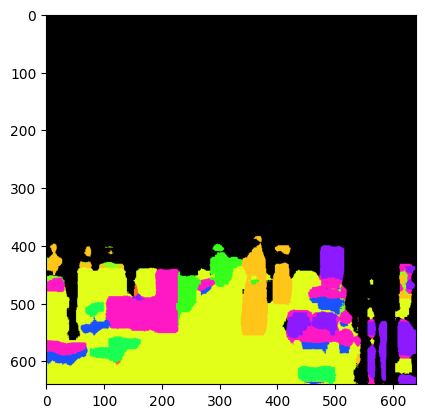

In [6]:
onnxMask = convert_index_to_image(torch.tensor(onnxOutputs), color_map)
import matplotlib.pyplot as plt

plt.imshow(np.array(onnxMask)[0])